# Разработка стратегии взаимодействия с клиентами для сети фитнес-центров

**Цель исследования** - подготовить план действий по удержанию клиентов сети фитнес-центров.

**Задачи исследования**:
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами (выделить целевые группы клиентов, предложить меры по снижению оттока, определить другие особенности взаимодействия с клиентами).

**Ход исследования**

Исследование пройдет в три этапа:
1. Исследовательский анализ данных (EDA)
2. Построение модели прогнозирования оттока клиентов
3. Кластеризация клиентов

## Загрузка данных

Импортируем необходимые библиотеки и сохраняем исходный файл в переменную.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
try:
    data = pd.read_csv(r'C:\Users\м\Documents\Data\gym_churn.csv')
except:
    data = pd.read_csv('/datasets/gym_churn.csv')

## Исследовательский анализ данных (EDA)

Выведем первые строки таблицы и информацию о данных на экран.

In [3]:
display(data.head())
display(data.info())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

Согласно документации к данным в таблице четырнадцать столбцов:

Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends`  факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

В таблице 4000 строк. Пропусков в данных нет. Представленные данные двух типов - целочисленный (int) и вещественный (float). В целом типы данных корректны, переведем только столбец со сроком до окончания текущего действующего абонемента в месяцах (`Month_to_end_contract`) в тип int.

In [4]:
data['Month_to_end_contract'] = data['Month_to_end_contract'].astype('int64')
data.dtypes

gender                                 int64
Near_Location                          int64
Partner                                int64
Promo_friends                          int64
Phone                                  int64
Contract_period                        int64
Group_visits                           int64
Age                                    int64
Avg_additional_charges_total         float64
Month_to_end_contract                  int64
Lifetime                               int64
Avg_class_frequency_total            float64
Avg_class_frequency_current_month    float64
Churn                                  int64
dtype: object

Для удобства приведем названия всех колонок к нижнему регистру.

In [5]:
data.columns = data.columns.str.lower()

Проверим таблицу на дубликаты.

In [6]:
data.duplicated().sum()

0

Полных строк-дубликатов нет.

С помощью метода `describe` посмотрим на статистические данные:

In [7]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Видим равномерное распределение клиентов по полу (почти 50 на 50). Также почти каждый второй клиент является сотрудником компании-партнера клуба. 84.5% клиентов живут или работают недалеко от фитнес-центра. По акции «приведи друга» пришел примерно каждый третий. 90% человек оставили контактный телефон. Средний возраст клиентов составляет 29 лет, при этом минимальный возраст - 18 лет, максимальный - 41 год. Средняя суммарная выручка от других услуг фитнес-центра - почти 147 у.е., при этом медиана несколько ниже - 136 у.е., стандартное отклонение довольно высокое (96.3). Вероятно, в данных есть выбросы. В пользу этого говорит и то, что максимальное значение выручки - 552.5 у.е., а 75-й процентиль - всего 210.9 у.е.   

Те клиенты, по которым у нас представлена информация, в среднем пользуются услугами фитнес-центра чуть больше 3.7 месяцев, но есть и те, кто занимается уже больше 2.5 лет. Возможно, в этом поле тоже присутствуют небольшие выбросы, так как медианное значение немного меньше среднего (3 месяца), а стандартное отклонение - 3.7. Средняя частота посещений в неделю за все время с начала действия абонемента - 1.87 (медиана примерно такая же), а за прошлый месяц - 1.76. Что касается оттока, в текущем месяце он составил 26.5%.

Теперь посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [8]:
data.groupby('churn').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Практически все средние значения признаков у тех, кто остался, выше. Равное распределение в двух группах только по полу и по оставившим свои контакты. Из тех, кто ушел в отток, 76.7% жили или работали в том же районе, где находится фитнес-центр, 35.5% являлись сотрудниками компании-партнера клуба. Те, что ушли, почти в два раза реже приходили по акции «приведи друга», чем те, что остались, а также они значительно реже посещали групповые занятия. Средний возраст тех, кто остался, - почти 30 лет, в другой группе на три года меньше - 27. Средняя суммарная выручка от других услуг фитнес-центра у тех, кто остался, тоже заметно выше. В среднем за последний месяц ушедшие посещали клуб один раз в неделю, оставшиеся - в два раза больше. В расчете за все время этот показатель более ровный - полтора и два раза соответственно.

Интересно посмотреть на показатели времени. Так, средняя длительность текущего действующего абонемента у тех, кто ушел, составляет меньше двух месяцев, а у тех, кто остался, она приближается к шести месяцам. Так же и со сроком до окончания текущего действующего абонемента: у ушедших - это 1.6 месяца, у оставшихся - 5.2 месяца. Но, самое главное, что средний лайфтайм тех клиентов, что ушли в отток,составляет всего один месяц (даже чуть меньше). Значит, у фитнес-центра есть проблемы с удержанием клиентов.     

Теперь построим столбчатые гистограммы и распределения небинарных признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

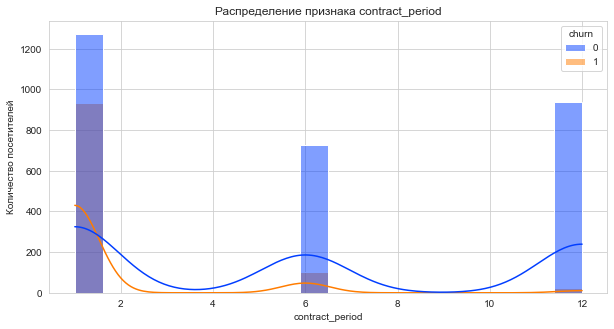

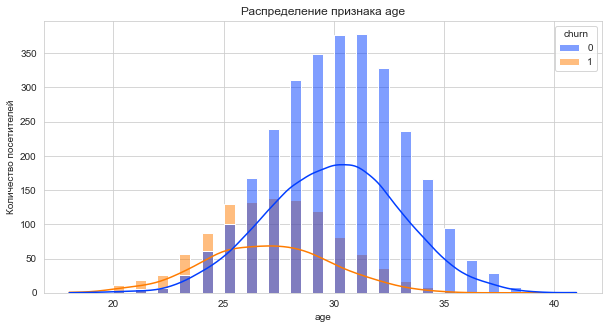

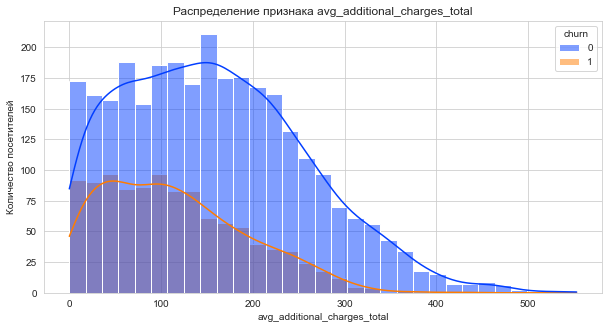

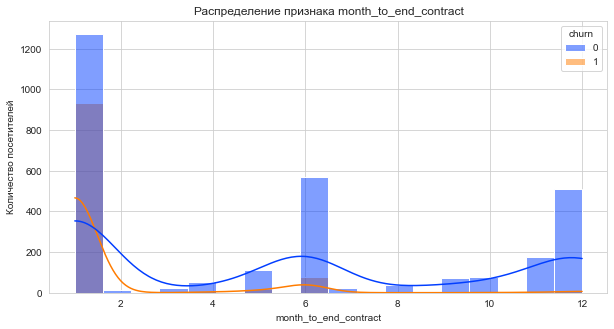

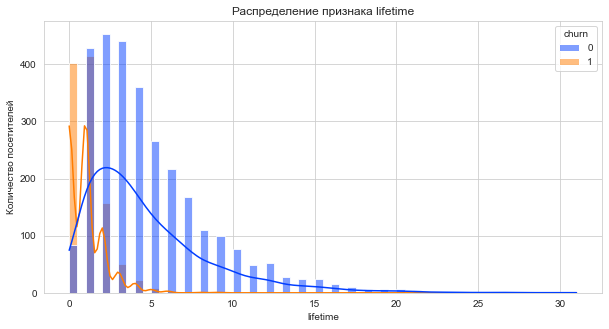

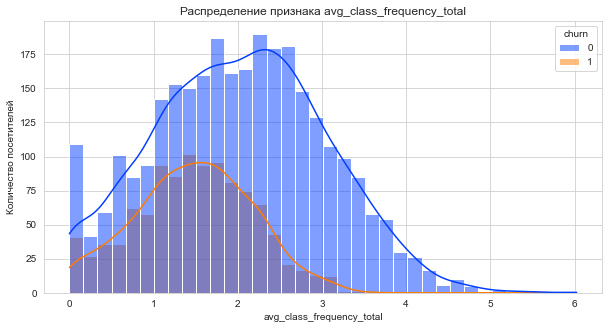

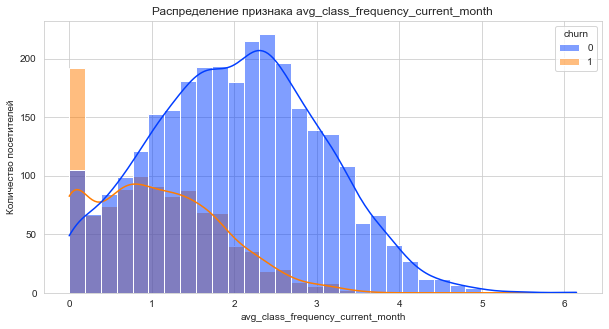

In [9]:
sns.set_style('whitegrid')
sns.set_palette('bright')

#строим гистограмму для каждого количественного признака с разбивкой по оттоку

for col in data.drop(['churn', 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits'],
                     axis = 1).columns:
    plt.figure(figsize=(10,5))
    sns.histplot(data = data, x = col, hue = 'churn', kde = True)
    plt.title('Распределение признака {}'.format(col))
    plt.ylabel('Количество посетителей')
    plt.show();

У большинства ушедших клиентов абонемент был сроком на месяц. Из тех же у кого абонемент на год почти никто не попал в отток. Видимо, что-то в фитнес-центре посетителей сильно не устраивает, поэтому они не продлевают абонементы на более длительный срок. Похожее распределение видим и на графике срока до окончания текущего действующего абонемента. Лайфтайм подавляющего большинства попавших в отток не составляет больше одного месяца. Графики количества посещений клуба в неделю показывают нормальное распределение, но видно как в последний месяц увеличилась доля ушедших среди тех, кто не посетил клуб ни разу за неделю. Что касается средней суммарной выручки от других услуг фитнес-центра, у тех, кто остался, она стабильно выше.

Построим матрицу корреляций и тепловую карту.

In [10]:
data.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


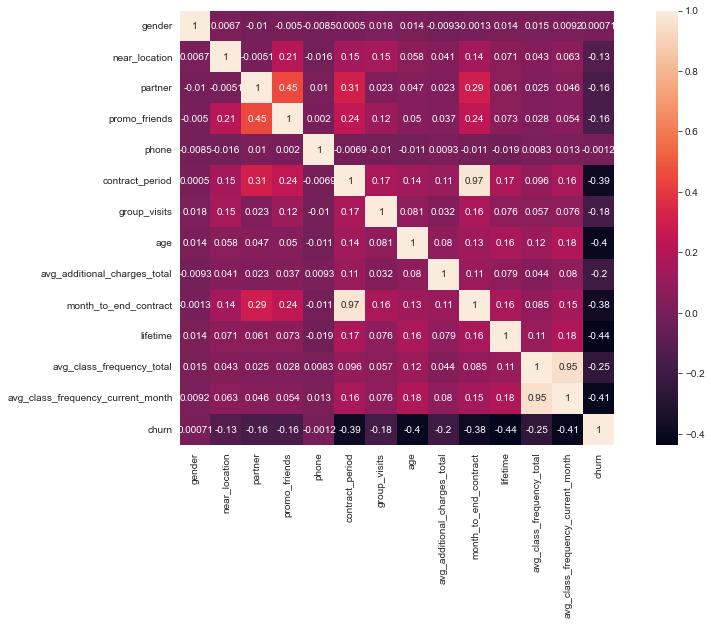

In [11]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot=True, square=True)
plt.show;

У большинства признаков корреляция между собой небольшая - от -0.3 до 0.3. Однако есть две пары признаков с очень сильной положительной корреляцией - 0.97 и 0.95. Это `contract_period` (длительность текущего действующего абонемента) и
`month_to_end_contract` (срок до окончания текущего действующего абонемента); `avg_class_frequency_total` (средняя частота посещений в неделю за все время с начала действия абонемента) и `avg_class_frequency_current_month` (средняя частота посещений в неделю за предыдущий месяц). Таким образом, возникает мультиколлинеарность. Для того, чтобы это исправить, для каждой пары сильно скоррелированных признаков удалим один:    

In [12]:
data = data.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis = 1)
data.shape[1]    #проверяем, сколько столбцов осталось

12

**Вывод:** На данном этапе мы обработали данные, привели их к единому формату. Также мы изучили распределение числовых признаков и выдвинули предварительную гипотезу о проблеме удержания клиентов в первый с момента их обращения в фитнес-центр месяц. С помощью матрицы корреляций и тепловой карты мы обнаружили мультиколлинеарность и избавились от нее, чтобы она не повлияла на обучение модели.

## Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Стратифицируем выборки по таргету, чтобы в тесте и трейне была одинаковая доля ушедших и оставшихся. 

In [13]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns=['churn'])
y = data['churn']

#разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = data['churn'])

#задаем список моделей
models = [
    LogisticRegression(random_state=0, solver = 'liblinear'),
    RandomForestClassifier(random_state=0)
]

In [14]:
#функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred)
        )
    )
    
#цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction( 
        m=i,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )
    
print('Соотношение классов:\n', data['churn'].value_counts())

LogisticRegression(random_state=0, solver='liblinear')
Accuracy:0.90 Precision:0.83 Recall:0.80
RandomForestClassifier(random_state=0)
Accuracy:0.89 Precision:0.81 Recall:0.79
Соотношение классов:
 0    2939
1    1061
Name: churn, dtype: int64


И логистическая регрессия, и случайный лес показывают высокую долю правильных ответов - 90% и 89% соответственно. Но в нашем случае эта метрика не сильно показательна, так как у нас не соблюдается условие баланса классов - тех, кто не попал в отток в три раза больше, чем ушедших. Метрики точности и полноты у обеих моделей пониже, над ними еще можно поработать. В целом же модель, обученная логистической регрессией, показывает себя немного лучше.   

## Кластеризация клиентов

Проведем кластеризацию объектов (клиентов). Для этого сначала стандартизируем данные и функцией `linkage()` построим матрицу расстояний.

In [15]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

Теперь нарисуем дендрограмму:

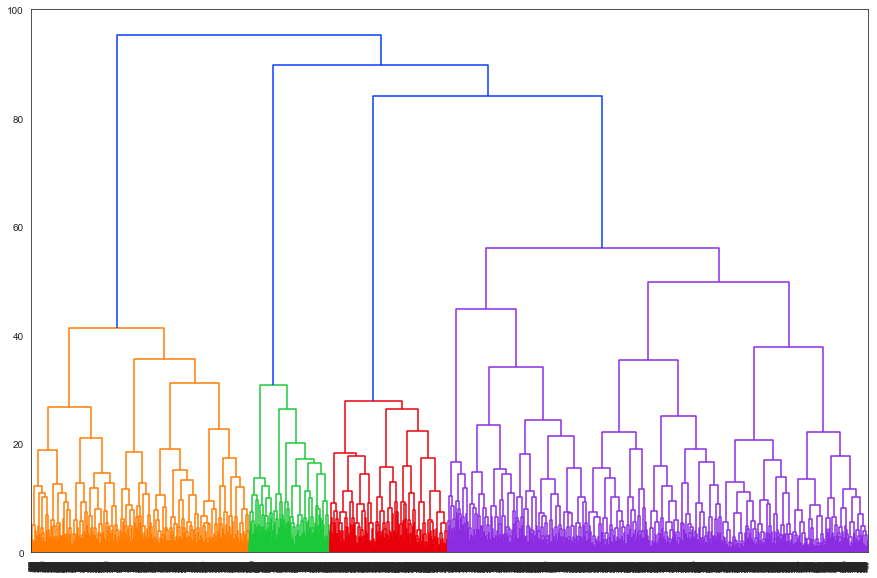

In [16]:
sns.set_style('white')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show(); 

Судя по дендрограмме, клиентов можно разделить на четыре кластера. Обучим модель кластеризации на основании более быстрого алгоритма K-Means и спрогнозируем кластеры клиентов. За число кластеров примем n=5.

In [17]:
#задаём модель k_means, фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state=0)

#прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

#сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels

In [18]:
data.groupby('cluster_km')['gender'].count()

cluster_km
0     561
1    1050
2    1132
3     871
4     386
Name: gender, dtype: int64

Кластеры получились совсем разными по размеру, поэтому посмотрим на средние значения признаков для кластеров.

In [19]:
#выводим статистику по средним значениям наших признаков по кластеру
data.groupby('cluster_km').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster_km,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Уже только по средним значениям видно, что есть два кластера (0 и 2), в которые попало большее количество ушедших клиентов (отток 40% и 38%). Соответственно в них же самый короткие сроки абонементов и лайфтайм клиентов и самая низкая посещаемость в неделю. В кластере номер 1, напротив, самые низкие показатели оттока, самый продолжительный средний срок абонемента, лучший лайфтайм и посещаемость. Примечательно, что почти все клиенты, попавшие в этот кластер, являются либо сотрудниками компаний-партнеров клуба, либо пришли по акции «приведи друга». Видимо, условия по двум этим программам очень привлекательные. 

Интересно, что в первый (0) кластер попали только те, кто не живет/работает рядом с фитнес-центром. В кластере 2 не оказалось ни одного человека, кто бы посещал групповые занятия. А в последний кластер попали все, кто не оставил контактный телефон. 

Отобразим данные по кластерам более наглядно - в виде графиков. Сначала построим распределения бинарных признаков.

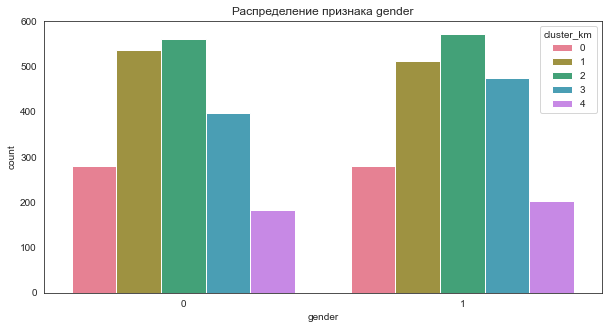

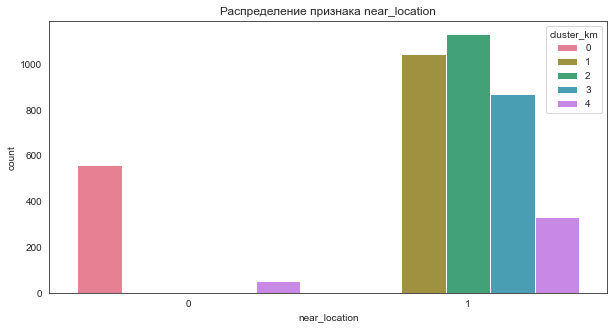

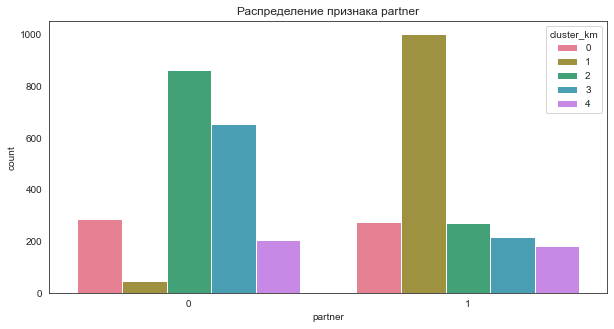

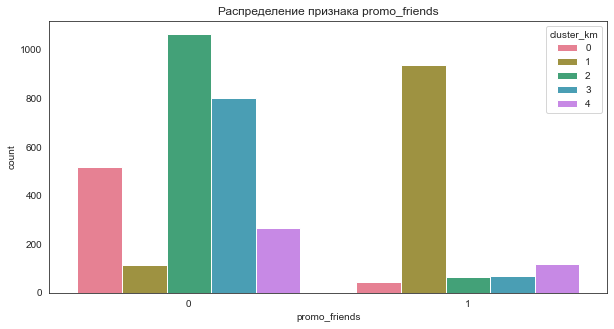

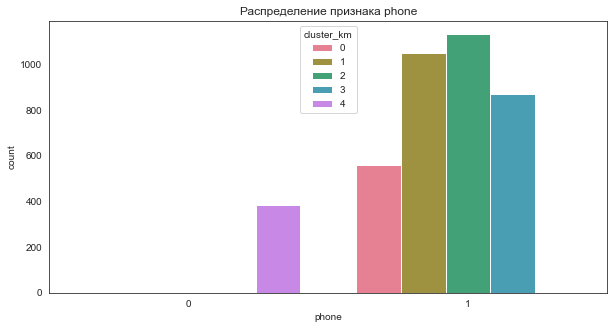

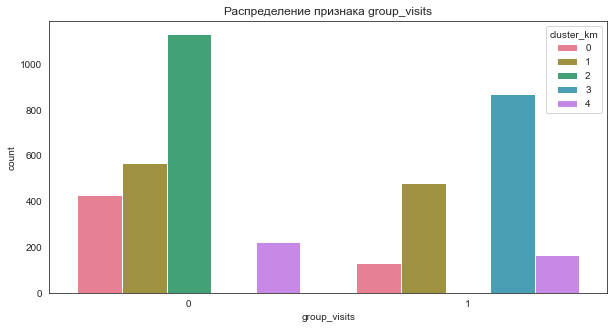

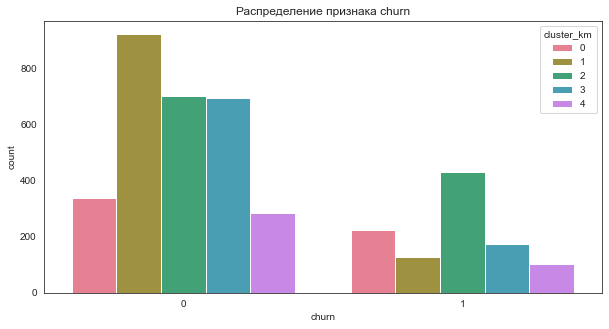

In [20]:
for col in data.drop(['contract_period', 'age', 'avg_additional_charges_total', 
                      'lifetime', 'avg_class_frequency_total', 'cluster_km'], axis = 1).columns:
    plt.figure(figsize=(10,5))
    sns.countplot(data = data, x = col, hue = 'cluster_km', palette = 'husl')
    plt.title('Распределение признака {}'.format(col))
    plt.show();

Гистограммы только подтверждают сделанные ранее выводы о преобладании одних и отсутствии других признаков в разных кластерах.

Построим распределения количественных признаков для кластеров.

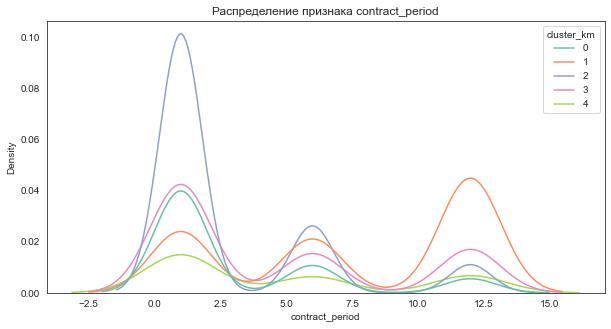

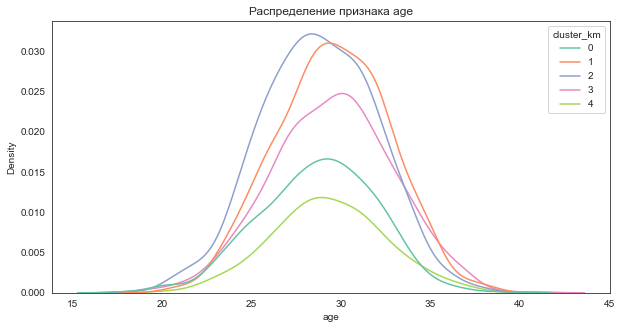

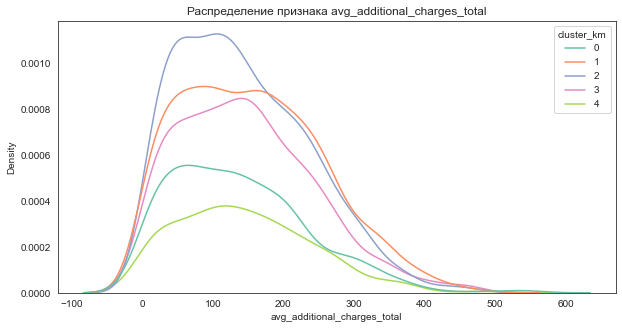

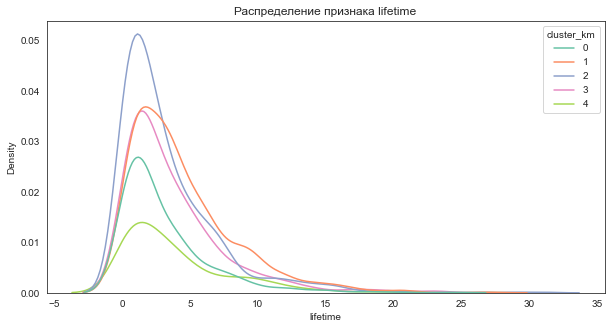

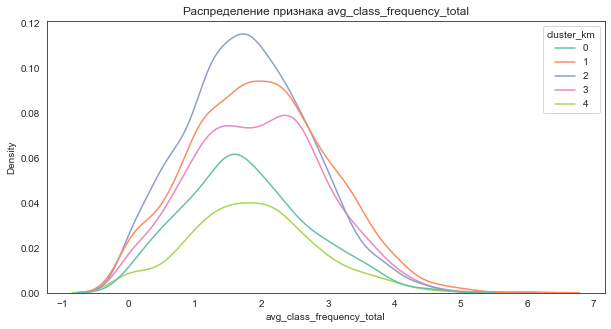

In [21]:
for col in data.drop(['churn', 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'cluster_km'],
                     axis = 1).columns:
    plt.figure(figsize=(10,5))
    sns.kdeplot(data = data, x = col, hue = 'cluster_km', palette = 'Set2')
    plt.title('Распределение признака {}'.format(col))
    plt.show();

Из графиков видно, что в кластере 2 сосредоточено много клиентов с коротким сроком абонемента, а в кластере 1 - наоборот. Также в кластере 1 лайфтайм клиентов подлиннее - данные меньше скошены вправо. 

Для каждого полученного кластера посчитаем долю оттока.

In [22]:
churn_share = data.groupby('cluster_km').agg({'churn':'mean'})
churn_share

,churn
cluster_km,
0,0.399287
1,0.120952
2,0.381625
3,0.200918
4,0.266839


Как мы уже выяснили, склонны к оттоку кластеры 0 и 2 (в них ушло 38-40% клиентов). Самый надежный кластер - 1 (ушло всего 12%).

**Вывод:** Мы стандартизировали данные и построили дендрограмму, которая предложила оптимальное число кластеров - 4. Однако при обучении модели кластеризации на основании алгоритма K-Means мы предположили, что кластеров должно быть 5. В результате мы получили кластеризацию, из которой можно выделить три условные группы клиентов:   

1. Первая группа (кластеры 0 и 2) - это клиенты, которые чаще всего попадают в отток. Для них характерны короткие длительность абонемента и лайфтайм, низкая посещаемость групповых занятий, невысокие траты на дополнительные услуги фитнес-центра. Среди них почти нет тех, кто пришел в рамках акции «приведи друга». Тем не менее внутри этой группы есть ряд клиентов, которых клубу вряд ли получится удержать. Речь про тех, кто живет/работает далеко от фитнес-центра. 
2. Вторая группа (кластер 1). В нее вошли самые надежные клиенты, которые дольше всего пользуются услугами клуба, реже уходят, имеют самый продолжительный средний срок абонемента и лучшую посещаемость. В основном эти клиенты пришли по корпоративной скидке или от друзей.
3. Третья группа (кластер 3 и 4) - это среднестатические клиенты. Они близко живут/работают от фитнес-центра, хорошо посещают групповые занятия, в среднем неплохо удерживаются.

## Вывод

В начале исследования мы оценили качество данных: убедились, что в них нет пропусков и значительных выбросов, проверили на наличие дубликатов. Мы изучили статистические данные (среднее, стандартное отклонение) и построили графики распределения числовых признаков. Мы выяснили, что у фитнес-центра есть проблемы с удержанием клиентов. Лайфтайм ушедших в отток клиентов составляет чуть меньше месяца, тогда как у остальных это 4.7 месяца. Помимо лайфтайма на отток сильно влияют такие признаки как срок действия абонемента, факт посещения групповых занятий и то, каким способом клиент впервые попал в клуб. Также с помощью матрицы корреляций мы обнаружили сильную корреляцию двух пар признаков и удалили по одному из каждой пары, чтобы модель не переобучалась под эти признаки.

Затем мы построили модель бинарной классификации клиентов, где целевой признак - факт оттока клиента в следующем месяце и обучили модель двумя способами: логистической регрессией и случайным лесом. По метрикам accuracy, precision и recall мы оценили, что модель, обученная логистической регрессией, показала себя немного лучше - у нее выше точность и полнота.

На основании алгоритма K-Means и после изучения дендрограммы мы обучили модель кластеризации и получили пять кластеров. Исследовав распределения признаков для кластеров, мы пришли к выводу, что можно выделить три типичных портрета клиентов: те, кто записались в клуб по корпоративному тарифу или акции «приведи друга», стабильно посещают его и имеют контракт на длительный срок; те, кто нерегулярно занимались в фитнес-центре 1-2 месяца и ушли; и остальные клиенты - у них средние показатели по всем показателям и невысокий отток.

Учитывая вышесказанное, можно дать следующие рекомендации для стратегии взаимодействия с клиентами и их удержания:
- в первую очередь необходимо направить внимание на клиентов, покупающих абонемент на один месяц:
    - среди них много тех, кто в принципе первый раз покупает абонемент в спортивный клуб. Для них нужно разработать систему помощи и наставничества, например, на первое время предложить услуги тренера, который поможет составить программу тренировок и установить цель на будущее. Также новички редко посещают групповые занятия, им бывает сложно разобраться в расписании и они не знают, как эти занятия проходят, поэтому стоит сделать их посещение более привлекательным. Они помогут клиентам почувствать свою принадлежность к коллективу и замотивироваться на дальнейшие занятия.   
    - другие клиенты находятся в поиске подходящего фитнес-центра и берут месяц на знакомство с клубом. Им стоит предложить выгодные условия продления абонемента - как вариант, два следующих месяца по цене одного или возможность посещать больше одного клуба сети.
- не стоит забывать о поддержании на должном уровне технических характеристик клуба - быстро ремонтировать/заменять неисправные тренажеры, добавлять новые, качественно проводить уборку помещений и т.д. Это поможет как сохранить текущих клиентов, так и заинтересовать новых.
- привлечение сотрудников компаний-партнеров и друзей клиентов дает хороший результат в виде новых лояльных пользователей. Можно расширить список партнеров и увеличить скидку по промокоду для друзей.